In [1]:
# --- Imports ---
import numpy as np
#import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler, random_split
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import kagglehub
dataset_path = kagglehub.dataset_download('jessicali9530/stanford-dogs-dataset')
raw_dataset = ImageFolder(dataset_path + '/images/Images')

In [2]:
# --- Step 2: Custom Albumentations Dataset ---
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)

        if self.transform:
            img = self.transform(image=img)['image']

        return img, label

In [3]:
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

In [4]:
# --- Step 4: Device Utilities ---
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [5]:
# --- Step 5: Base Training Class ---
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        _, preds = torch.max(out, dim=1)
        return {
            'val_loss': loss.detach(),
            'preds': preds.cpu(),
            'labels': labels.cpu()
        }

    def validation_epoch_end(self, outputs):
        val_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(val_losses).mean().item()
        all_preds = torch.cat([x['preds'] for x in outputs])
        all_labels = torch.cat([x['labels'] for x in outputs])
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        kappa = cohen_kappa_score(all_labels, all_preds)
        bal_acc = balanced_accuracy_score(all_labels, all_preds)
        return {
            'val_loss': epoch_loss,
            'val_acc': acc,
            'val_f1': f1,
            'val_kappa': kappa,
            'val_bal_acc': bal_acc
        }

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], Train Loss: {result['train_loss']:.4f}, Val Loss: {result['val_loss']:.4f}, "
              f"Acc: {result['val_acc']:.4f}, F1: {result['val_f1']:.4f}, "
              f"Kappa: {result['val_kappa']:.4f}, Balanced Acc: {result['val_bal_acc']:.4f}")

In [6]:
# --- Step 6: EfficientNet Model ---
class EfficientNetClassifier(ImageClassificationBase):
    def __init__(self, num_classes=120):
        super().__init__()
        self.network = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.network.classifier[1] = nn.Linear(self.network.classifier[1].in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [7]:
# --- Step 7: Training Utilities ---
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [8]:
# --- Step 8: Stratified K-Fold Setup ---
labels = [sample[1] for sample in raw_dataset.samples]
train_indices, test_indices = train_test_split(np.arange(len(labels)), test_size=0.1, stratify=labels, random_state=42)

train_labels = [labels[i] for i in train_indices]
device = get_default_device()
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_labels)), train_labels)):
    print(f'\n--- Fold {fold + 1} ---')
    fold_train_indices = [train_indices[i] for i in train_idx]
    fold_val_indices = [train_indices[i] for i in val_idx]

    train_subset = Subset(raw_dataset, fold_train_indices)
    val_subset = Subset(raw_dataset, fold_val_indices)

    train_ds = AlbumentationsDataset(train_subset, transform=get_transforms(train=True))
    val_ds = AlbumentationsDataset(val_subset, transform=get_transforms(train=False))

    class_counts = np.bincount([raw_dataset[i][1] for i in fold_train_indices])
    class_weights = 1. / class_counts
    sample_weights = [class_weights[raw_dataset[i][1]] for i in fold_train_indices]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    train_dl = DataLoader(train_ds, batch_size=64, sampler=sampler, num_workers=2, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)

    model = to_device(EfficientNetClassifier(num_classes=len(raw_dataset.classes)), device)
    history = fit(epochs=10, lr=0.001, model=model, train_loader=train_dl, val_loader=val_dl)


--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 160MB/s]


Epoch [0], Train Loss: 1.7785, Val Loss: 1.2482, Acc: 0.6197, F1: 0.6139, Kappa: 0.6164, Balanced Acc: 0.6172
Epoch [1], Train Loss: 0.9251, Val Loss: 1.1721, Acc: 0.6539, F1: 0.6473, Kappa: 0.6509, Balanced Acc: 0.6546
Epoch [2], Train Loss: 0.7010, Val Loss: 1.0566, Acc: 0.6876, F1: 0.6845, Kappa: 0.6849, Balanced Acc: 0.6838
Epoch [3], Train Loss: 0.5824, Val Loss: 1.1601, Acc: 0.6660, F1: 0.6630, Kappa: 0.6632, Balanced Acc: 0.6638
Epoch [4], Train Loss: 0.4671, Val Loss: 1.1362, Acc: 0.6799, F1: 0.6732, Kappa: 0.6772, Balanced Acc: 0.6761
Epoch [5], Train Loss: 0.4242, Val Loss: 1.1555, Acc: 0.6879, F1: 0.6804, Kappa: 0.6852, Balanced Acc: 0.6826
Epoch [6], Train Loss: 0.3634, Val Loss: 1.1425, Acc: 0.6913, F1: 0.6879, Kappa: 0.6887, Balanced Acc: 0.6892
Epoch [7], Train Loss: 0.3126, Val Loss: 1.3657, Acc: 0.6706, F1: 0.6632, Kappa: 0.6677, Balanced Acc: 0.6671
Epoch [8], Train Loss: 0.2950, Val Loss: 1.3013, Acc: 0.6817, F1: 0.6784, Kappa: 0.6790, Balanced Acc: 0.6770
Epoch [9],

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Epoch [0], Train Loss: 1.7839, Val Loss: 1.2585, Acc: 0.6241, F1: 0.6164, Kappa: 0.6209, Balanced Acc: 0.6231
Epoch [1], Train Loss: 0.9177, Val Loss: 1.1216, Acc: 0.6725, F1: 0.6655, Kappa: 0.6697, Balanced Acc: 0.6697
Epoch [2], Train Loss: 0.7059, Val Loss: 1.1187, Acc: 0.6777, F1: 0.6689, Kappa: 0.6749, Balanced Acc: 0.6752
Epoch [3], Train Loss: 0.5770, Val Loss: 1.1078, Acc: 0.6858, F1: 0.6793, Kappa: 0.6831, Balanced Acc: 0.6815
Epoch [4], Train Loss: 0.4778, Val Loss: 1.1599, Acc: 0.6804, F1: 0.6748, Kappa: 0.6777, Balanced Acc: 0.6766
Epoch [5], Train Loss: 0.3996, Val Loss: 1.2240, Acc: 0.6804, F1: 0.6751, Kappa: 0.6777, Balanced Acc: 0.6778
Epoch [6], Train Loss: 0.3653, Val Loss: 1.2248, Acc: 0.6778, F1: 0.6736, Kappa: 0.6751, Balanced Acc: 0.6742
Epoch [7], Train Loss: 0.3104, Val Loss: 1.2313, Acc: 0.6848, F1: 0.6811, Kappa: 0.6821, Balanced Acc: 0.6806
Epoch [8], Train Loss: 0.2913, Val Loss: 1.2726, Acc: 0.6790, F1: 0.6747, Kappa: 0.6762, Balanced Acc: 0.6761
Epoch [9],

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Epoch [0], Train Loss: 1.7985, Val Loss: 1.1809, Acc: 0.6429, F1: 0.6325, Kappa: 0.6398, Balanced Acc: 0.6381
Epoch [1], Train Loss: 0.8986, Val Loss: 1.2016, Acc: 0.6526, F1: 0.6418, Kappa: 0.6496, Balanced Acc: 0.6487
Epoch [2], Train Loss: 0.7001, Val Loss: 1.0953, Acc: 0.6845, F1: 0.6783, Kappa: 0.6818, Balanced Acc: 0.6821
Epoch [3], Train Loss: 0.5938, Val Loss: 1.1015, Acc: 0.6916, F1: 0.6854, Kappa: 0.6890, Balanced Acc: 0.6897
Epoch [4], Train Loss: 0.4953, Val Loss: 1.1952, Acc: 0.6819, F1: 0.6774, Kappa: 0.6792, Balanced Acc: 0.6795
Epoch [5], Train Loss: 0.4284, Val Loss: 1.1427, Acc: 0.6945, F1: 0.6882, Kappa: 0.6919, Balanced Acc: 0.6929
Epoch [6], Train Loss: 0.3721, Val Loss: 1.1394, Acc: 0.7089, F1: 0.7040, Kappa: 0.7065, Balanced Acc: 0.7075
Epoch [7], Train Loss: 0.3350, Val Loss: 1.1830, Acc: 0.6927, F1: 0.6869, Kappa: 0.6901, Balanced Acc: 0.6907
Epoch [8], Train Loss: 0.2998, Val Loss: 1.3110, Acc: 0.6869, F1: 0.6839, Kappa: 0.6843, Balanced Acc: 0.6863
Epoch [9],

In [8]:

model = EfficientNetClassifier(num_classes=120)
model_path = "C:/Users/AdityaC/OneDrive/Desktop/New folder/slate/effNet.pth"

# Solution 2: Or use this more flexible approach
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Important: set to eval mode


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\AdityaC/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 22.0MB/s]


EfficientNetClassifier(
  (network): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
           

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\AdityaC\\anaconda3\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



✅ Predicted Label: n02085782-Japanese_spaniel
🎯 Actual Label: n02085782-Japanese_spaniel


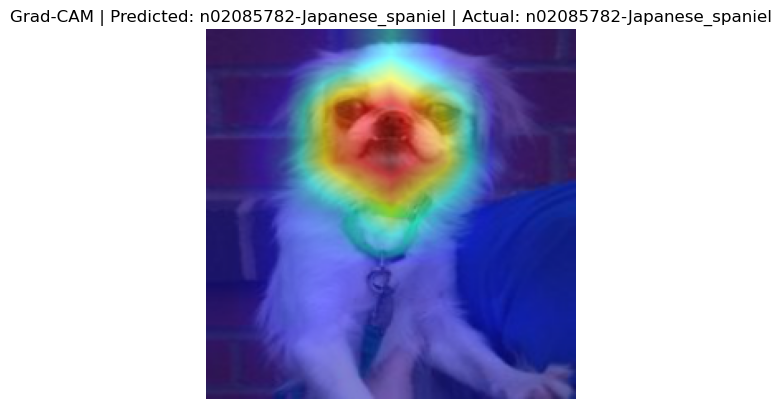

In [9]:
%pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import cv2

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np

# === Step 1: Choose an image index from the raw dataset ===
img_index = 202
first_img, actual_label = raw_dataset[img_index]
img_np = np.array(first_img)

# === Step 2: Preprocess image (same as validation transform) ===
val_transform = get_transforms(train=False)
input_tensor = val_transform(image=img_np)['image'].unsqueeze(0)

# Move input and model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)
model = model.to(device)

# === Step 3: Setup GradCAM ===
target_layer = model.network.features[-1]  # Last feature block
cam = GradCAM(model=model, target_layers=[target_layer])  # ❌ no use_cuda here

# === Step 4: Forward Pass and Prediction ===
model.eval()
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
targets = [ClassifierOutputTarget(pred_class)]

# === Step 5: Compute GradCAM ===
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# === Step 6: Overlay on original image ===
resized_img = cv2.resize(img_np, (224, 224))  # Resize to match input
rgb_img = resized_img.astype(np.float32) / 255.0  # Normalize to [0, 1]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# === Step 7: Display CAM ===
predicted_label_name = raw_dataset.classes[pred_class]
actual_label_name = raw_dataset.classes[actual_label]

print(f"✅ Predicted Label: {predicted_label_name}")
print(f"🎯 Actual Label: {actual_label_name}")

plt.imshow(cam_image)
plt.title(f"Grad-CAM | Predicted: {predicted_label_name} | Actual: {actual_label_name}")
plt.axis('off')
plt.show()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/1000 [00:00<?, ?it/s]

✅ LIME Predicted Label: n02085782-Japanese_spaniel
🎯 Actual Label: n02085782-Japanese_spaniel


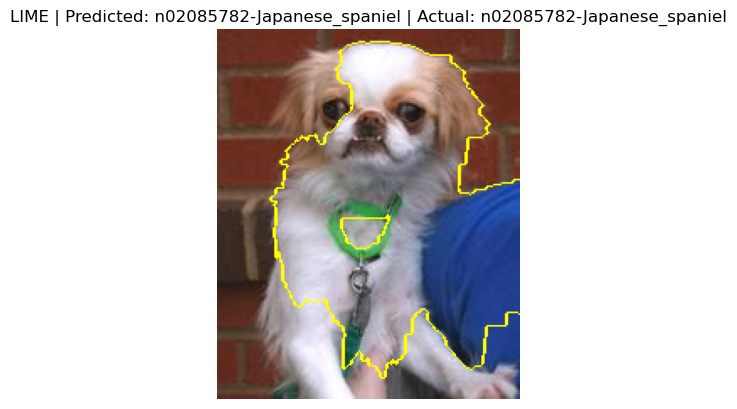

In [10]:
%pip install lime
%pip install scikit-image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from torchvision import transforms as T
import matplotlib.pyplot as plt
import numpy as np

# === Step 1: Pick an image ===
img_index = 202
original_img, actual_label = raw_dataset[img_index]
img_np = np.array(original_img)

# === Step 2: Define prediction function ===
# LIME works on numpy images, expects shape (N, H, W, C)
def predict(images):
    model.eval()
    batch = []

    transform = get_transforms(train=False)  # Albumentations transform
    for img in images:
        img_t = transform(image=img)['image']
        batch.append(img_t)

    batch_tensor = torch.stack(batch).to(device)
    logits = model(batch_tensor)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

# === Step 3: Initialize LIME Explainer ===
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image=img_np,
    classifier_fn=predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000  # increase for better results
)

# === Step 4: Get LIME Explanation for predicted class ===
pred_class = model(val_transform(image=img_np)['image'].unsqueeze(0).to(device)).argmax(dim=1).item()

lime_image_np, mask = explanation.get_image_and_mask(
    label=pred_class,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# === Step 5: Display with boundaries ===
lime_image_vis = mark_boundaries(lime_image_np / 255.0, mask)

predicted_label_name = raw_dataset.classes[pred_class]
actual_label_name = raw_dataset.classes[actual_label]

print(f"✅ LIME Predicted Label: {predicted_label_name}")
print(f"🎯 Actual Label: {actual_label_name}")

plt.imshow(lime_image_vis)
plt.title(f"LIME | Predicted: {predicted_label_name} | Actual: {actual_label_name}")
plt.axis('off')
plt.show()


In [12]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/MyDrive/model_weights.pth')

Mounted at /content/drive
